In [193]:
import numpy as np
import pandas as pd
import re

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import csv
plt.style.use('seaborn')

### to do
1. Clean up incorrectly formatted times.
2. Add in gender distribution.
3. Mean SD

In [194]:
## drop unnecessary stuff
raw_df = pd.read_csv('erg1_f21.csv')
df = raw_df.drop(['Questions, comments? other?', 'Did you send a pic of your time trial splits to one of the coaches?'], axis=1)
df = df.drop_duplicates()
df = df.rename(columns={"500m Time (M:SS:X)":"overall_time", "Time (MM:SS:X) (PLEASE USE ONLYS COLONS (:) not DECIMALS!!). 2:30:0 NOT 2:30.0!!!":"overall_time", "Split 1 (MM:SS:X)": "split_1", "Split 2 (MM:SS:X)": "split_2", "Split 3 (MM:SS:X)":"split_3", "Split 4 (MM:SS:X)":"split_4", "Split 5 (MM:SS:X)":"split_5"})
df = df.drop(['Split 1 (M:SS.X)', 'Split 2 (M:SS.X)', 'Split 3 (M:SS.X)', 'Split 4 (M:SS.X)', 'Split 5 (M:SS.X)', 'Gender.1'], axis=1)
df.head()

,Timestamp,Name,Gender,Pic received?,overall_time,Side,Weight (lb),split_1,split_2,split_3,split_4,split_5
0,01/10/2021 20:34:10,Shine Lee,m,Rosa,3:00:0,Left,154,2:49.5,2:46:5,2:55:0,3:10:0,3:19:0
1,03/10/2021 22:37:26,Daniel Shevelev,m,NaN,2:38:5,Right,170,2:27.5,2:24:0,2:40:0,2:50:0,2:51:1
2,04/10/2021 21:31:45,Ethan Garcia,m,NaN,2:16:9,Right,144,2:09:0,2:05:0,2:11:0,2:22:0,2:37:5
3,06/10/2021 11:35:20,Yuki Schwab,f,Angie,2:56:5,Right,113,0:34:3,0:34:6,0:35:2,0:35:5,0:36:9
4,06/10/2021 12:04:28,Anson Wong,f,Angie,2:37:5,Right,122,2:32:0,2:31:0,2:36:0,2:42:0,2:45:0


In [195]:
# roster comparison
roster = pd.read_csv('roster_f21.csv')
paddlers = np.array(roster['Name'])
paddlers
df.head()

,Timestamp,Name,Gender,Pic received?,overall_time,Side,Weight (lb),split_1,split_2,split_3,split_4,split_5
0,01/10/2021 20:34:10,Shine Lee,m,Rosa,3:00:0,Left,154,2:49.5,2:46:5,2:55:0,3:10:0,3:19:0
1,03/10/2021 22:37:26,Daniel Shevelev,m,NaN,2:38:5,Right,170,2:27.5,2:24:0,2:40:0,2:50:0,2:51:1
2,04/10/2021 21:31:45,Ethan Garcia,m,NaN,2:16:9,Right,144,2:09:0,2:05:0,2:11:0,2:22:0,2:37:5
3,06/10/2021 11:35:20,Yuki Schwab,f,Angie,2:56:5,Right,113,0:34:3,0:34:6,0:35:2,0:35:5,0:36:9
4,06/10/2021 12:04:28,Anson Wong,f,Angie,2:37:5,Right,122,2:32:0,2:31:0,2:36:0,2:42:0,2:45:0


In [196]:
## finds ppl who didnt submit
submitted = np.array(df['Name'])
no_submission = list(set(paddlers) - set(submitted))
no_submission = np.append(['Rachel Ng'], no_submission[2:])
no_submission
# insert roster thing here

array(['Rachel Ng', 'Hyunju Lee', 'Brandon Marin', 'Clark Wang',
       'Junlong Li', 'Hannah Shlesinger', 'Ben Yoshida', 'Titanium Wang',
       'Edison Chadwick', 'Sean Chen', 'Romi Takara', 'Jiwon Shin',
       'Cameron Swiecki ', 'Ethan Yan', 'Shani Lyubomirsky', 'Lim Deng',
       'Rosa Zhang', 'Wardell Kim', 'Collin Miller', 'Angie Wu',
       'Codie Chang', 'Quoc'], dtype='<U17')

In [197]:
## finds ppl who didnt submit a pic
no_pic = df[df['Pic received?'].isna()]
no_pic['Name']
df.head()

,Timestamp,Name,Gender,Pic received?,overall_time,Side,Weight (lb),split_1,split_2,split_3,split_4,split_5
0,01/10/2021 20:34:10,Shine Lee,m,Rosa,3:00:0,Left,154,2:49.5,2:46:5,2:55:0,3:10:0,3:19:0
1,03/10/2021 22:37:26,Daniel Shevelev,m,NaN,2:38:5,Right,170,2:27.5,2:24:0,2:40:0,2:50:0,2:51:1
2,04/10/2021 21:31:45,Ethan Garcia,m,NaN,2:16:9,Right,144,2:09:0,2:05:0,2:11:0,2:22:0,2:37:5
3,06/10/2021 11:35:20,Yuki Schwab,f,Angie,2:56:5,Right,113,0:34:3,0:34:6,0:35:2,0:35:5,0:36:9
4,06/10/2021 12:04:28,Anson Wong,f,Angie,2:37:5,Right,122,2:32:0,2:31:0,2:36:0,2:42:0,2:45:0


In [198]:
# convert splits
for i in np.arange(0,6):
    col_name = 'split_%s' % i
    if i == 0:
        col_name = 'overall_time'
    time_col = np.array(df[col_name])
    new_time = []
    for j in np.arange(len(time_col)):
        split_str = time_col[j]
        arr = np.array(split_str.split(':')).astype(np.double)
        seconds = arr.item(0)*60 + arr.item(1)
        new_time = np.append(seconds, new_time)
    df = df.drop([col_name], axis=1)
    df[col_name+'_seconds'] = new_time
df.head()

,Timestamp,Name,Gender,Pic received?,Side,Weight (lb),overall_time_seconds,split_1_seconds,split_2_seconds,split_3_seconds,split_4_seconds,split_5_seconds
0,01/10/2021 20:34:10,Shine Lee,m,Rosa,Left,154,164.0,143.0,143.0,164.0,188.0,182.0
1,03/10/2021 22:37:26,Daniel Shevelev,m,NaN,Right,170,209.0,193.0,208.0,217.0,224.0,202.0
2,04/10/2021 21:31:45,Ethan Garcia,m,NaN,Right,144,147.0,143.0,142.0,148.0,152.0,151.0
3,06/10/2021 11:35:20,Yuki Schwab,f,Angie,Right,113,166.0,155.0,162.0,172.0,173.0,169.0
4,06/10/2021 12:04:28,Anson Wong,f,Angie,Right,122,171.0,149.0,165.0,177.0,187.0,181.0


In [199]:
womens = df.loc[df['Gender'] == 'f']
mens = df.loc[df['Gender'] == 'm']
mens

,Timestamp,Name,Gender,Pic received?,Side,Weight (lb),overall_time_seconds,split_1_seconds,split_2_seconds,split_3_seconds,split_4_seconds,split_5_seconds
0,01/10/2021 20:34:10,Shine Lee,m,Rosa,Left,154,164.0,143.0,143.0,164.0,188.0,182.0
1,03/10/2021 22:37:26,Daniel Shevelev,m,NaN,Right,170,209.0,193.0,208.0,217.0,224.0,202.0
2,04/10/2021 21:31:45,Ethan Garcia,m,NaN,Right,144,147.0,143.0,142.0,148.0,152.0,151.0
5,06/10/2021 21:52:13,Luke Chang,m,rosa,Right,140,176.0,162.0,168.0,175.0,185.0,191.0
6,07/10/2021 18:32:27,Sean He,m,rosa,Right,170,200.0,39.0,41.0,41.0,40.0,36.0
8,13/10/2021 09:18:20,Scott Yuki,m,Angie,Right,150,160.5,151.5,152.0,159.5,168.0,171.5
9,13/10/2021 16:49:10,Sean Zeng,m,Angie,Right,215,167.0,167.0,170.0,169.0,166.0,165.0
16,15/10/2021 10:35:26,William Hastings,m,evan,Right,150,124.0,114.0,113.0,123.0,133.0,139.0
17,15/10/2021 11:36:11,Edison,m,evan,Left,145,153.0,30.0,28.0,30.0,32.0,32.0
18,15/10/2021 14:29:22,Ryan Lee,m,rosa,Left,150,226.9,207.0,216.0,228.0,240.0,242.0


In [200]:
sd_times = []

for index, row in df.iterrows():
    name = row['Name']
    indiv_splits = []
    indiv_std = 0
    
    for i in np.arange(1, 5):
        split_num = 'split_%s_seconds' % i
        indiv_splits = np.append(indiv_splits, row[split_num])
    
    indiv_std = np.std(indiv_splits, dtype=np.float64)
    #indiv_times[name] = indiv_std
    sd_times = np.append(sd_times, indiv_std)

df['SD (seconds)'] = sd_times

<AxesSubplot:title={'center':'Team-wide 500m time vs standard deviation across 100m splits'}, xlabel='overall_time_seconds', ylabel='SD (seconds)'>

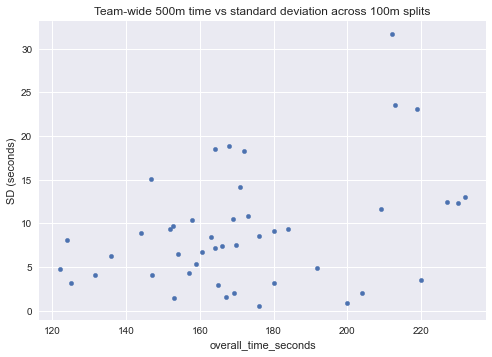

In [201]:
df.plot(kind='scatter',x='overall_time_seconds',y='SD (seconds)',
        xlabel='Overall time (seconds)', ylabel='SD (seconds)',
        title='Team-wide 500m time vs standard deviation across 100m splits')


In [202]:
all_mean_SD = np.mean(df['SD (seconds)'])
all_mean_SD

9.020853142186597

In [203]:
df
df.to_csv('cleaned_erg1_f21.csv')